# **Reprise de l'exemple fourni** : Sentence Embedding

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases (ici des tweets)
* L'objectif est de pouvoir séparer les sentiments des tweets de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions
* C'est un notebook d'exemples afin de mieux comprendre la mise en oeuvre des techniques. Il n'est pas optimisé et doit être adapté à un nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (model_type) idéalement pré-entraînés sur des données similaires au contexte (ici le modèle 'cardiffnlp/twitter-roberta-base-sentiment' surperforme le modèle de base car il a été pré-entraîné sur des tweets)
    * La taille des vecteurs (max_length)
    * Le batch_size
    * La perplexité du Tsne (perplexity à 30 par défaut)

# Chargement des données

(14640, 14)


,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
tweet_id,14640,14485,0,1.000000,0.989413,int64
airline_sentiment,14640,3,0,1.000000,0.000205,object
airline_sentiment_confidence,14640,1023,0,1.000000,0.069877,float64
negativereason,9178,10,5462,0.626913,0.001090,object
negativereason_confidence,10522,1410,4118,0.718716,0.134005,float64
airline,14640,6,0,1.000000,0.000410,object
airline_sentiment_gold,40,3,14600,0.002732,0.075000,object
name,14640,7701,0,1.000000,0.526025,object
negativereason_gold,32,13,14608,0.002186,0.406250,object
retweet_count,14640,18,0,1.000000,0.001230,int64


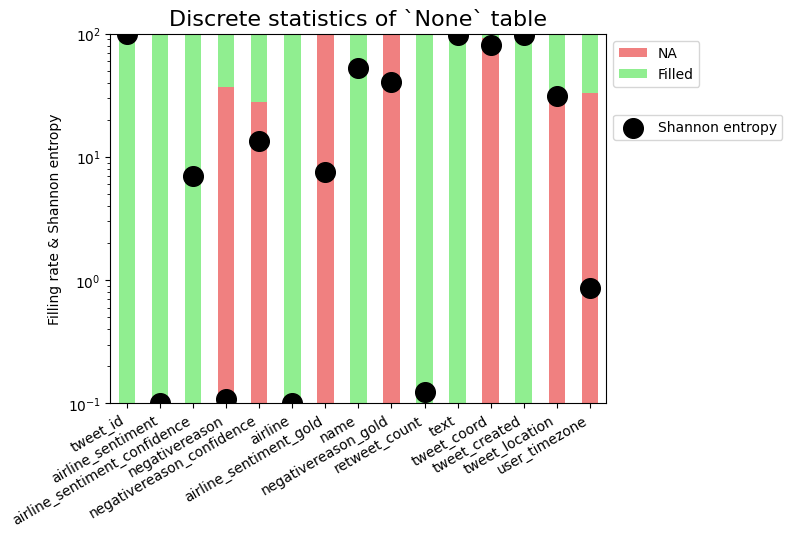

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
569578441508458496,negative,1.0000,Customer Service Issue,0.6425,United,NaN,_Charette_,NaN,0,@united I'm DMing my info and no is assisting....,NaN,2015-02-22 11:24:17 -0800,SE AZ By Way of HV,Mountain Time (US & Canada)
568170493544673280,negative,1.0000,Lost Luggage,0.6403,Southwest,NaN,thisnamerocks2,NaN,0,@SouthwestAir we've now lost a whole day of ou...,NaN,2015-02-18 14:09:36 -0800,"Canton, MA",NaN
570011533205336064,negative,0.6768,Late Flight,0.3434,US Airways,NaN,rgarrets,NaN,0,@USAirways #686 is delayed due to tail winds a...,NaN,2015-02-23 16:05:14 -0800,"philadephia, pa",NaN
568558887290441728,negative,1.0000,Bad Flight,0.6990,Delta,NaN,superhilarious,NaN,0,@JetBlue :/ he was trying to take stuff from t...,NaN,2015-02-19 15:52:56 -0800,NaN,Central Time (US & Canada)
570190092213465089,neutral,1.0000,NaN,NaN,Southwest,NaN,emayteeteej,NaN,0,@SouthwestAir quick question - i bought wifi f...,NaN,2015-02-24 03:54:46 -0800,"Hopatcong, NJ",NaN


In [1]:
from example import load
from pepper_commons import show_discrete_stats

raw_tweets = load('Tweets.csv')
print(raw_tweets.shape)
show_discrete_stats(raw_tweets.reset_index())
display(raw_tweets.sample(5))

## Filtrage sur un niveau de confiance maximal du sentiment

In [2]:
raw_tweets.airline_sentiment_confidence.value_counts(normalize=True)

1.0000    0.713456
0.6667    0.004850
0.6632    0.002391
0.6596    0.002049
0.6559    0.002049
            ...   
0.3674    0.000068
0.6155    0.000068
0.3708    0.000068
0.6905    0.000068
0.3487    0.000068
Name: airline_sentiment_confidence, Length: 1023, dtype: float64

In [3]:
# Filtre de tweets avec un niveau de confiance à 1 sur le sentiment
import pandas as pd
raw_tweets = raw_tweets[raw_tweets.airline_sentiment_confidence == 1]

print(raw_tweets.shape)
vc = pd.concat([
    raw_tweets.airline_sentiment.value_counts().rename('#'),
    raw_tweets.airline_sentiment.value_counts(normalize=True).rename('%')
], axis=1)
display(vc)

(10445, 14)


,#,%
negative,7382,0.706750
neutral,1548,0.148205
positive,1515,0.145045


# Echantillonage

Ehantillon de 3000 tweets, associés à un sentiment pour moitié positif, pour moitié négatif.

In [4]:
from example import old_3k_sample, tweets_3k_sample

rt_old_3k_sample = old_3k_sample(raw_tweets)
rt_3k_sample = tweets_3k_sample(raw_tweets)

(3000, 14)

(3000, 14)

# Nettoyage du texte

In [5]:
from example import preprocess, save_as

preprocess(rt_old_3k_sample)
preprocess(rt_3k_sample)

save_as(rt_old_3k_sample, 'old_3k_sample_clean.csv')
save_as(rt_3k_sample, '3k_sample_clean.csv')

# Préparation commune des traitements

## Lecture dataset

(3000, 17)


,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
tweet_id,3000,2988,0,1.000000,0.996000,int64
airline_sentiment,3000,2,0,1.000000,0.000667,object
airline_sentiment_confidence,3000,1,0,1.000000,0.000333,float64
negativereason,1500,10,1500,0.500000,0.006667,object
negativereason_confidence,1500,518,1500,0.500000,0.345333,float64
airline,3000,6,0,1.000000,0.002000,object
airline_sentiment_gold,5,2,2995,0.001667,0.400000,object
name,3000,2488,0,1.000000,0.829333,object
negativereason_gold,3,2,2997,0.001000,0.666667,object
retweet_count,3000,11,0,1.000000,0.003667,int64


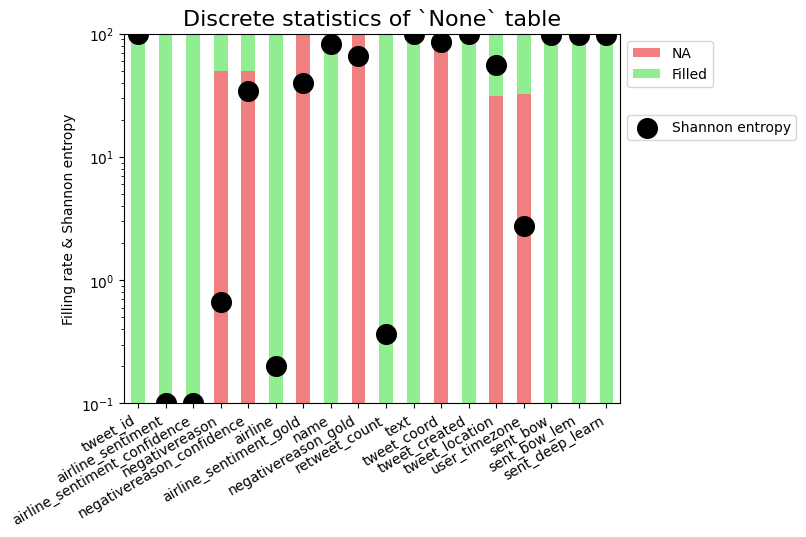

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,sent_bow,sent_bow_lem,sent_deep_learn
tweet_id,,,,,,,,,,,,,,,,,
568814284680994816,negative,1.0,Customer Service Issue,0.6485,US Airways,NaN,CLChicosky,NaN,0,@sarahpompei don't bother wasting your time! ...,NaN,2015-02-20 08:47:48 -0800,NaN,NaN,sarahpompei n't bother wasting time usairways ...,sarahpompei n't bother wasting time usairways ...,sarahpompei do n't bother wasting your time ! ...
568425737092513792,positive,1.0,NaN,NaN,Southwest,NaN,MJonTravel,NaN,1,@SouthwestAir - thanks to the agent boarding 1...,NaN,2015-02-19 07:03:51 -0800,ATL,Quito,southwestair thanks agent boarding 1137 atl au...,southwestair thanks agent boarding 1137 atl au...,southwestair thanks to the agent boarding 1137...
568947542899052544,positive,1.0,NaN,NaN,United,NaN,mrp,NaN,0,@united I just received notification of in-fli...,NaN,2015-02-20 17:37:19 -0800,sf - austin - sydney,Alaska,united received notification flight ua863 flys...,united received notification flight ua863 flys...,united i just received notification of in flig...
568426494554480640,positive,1.0,NaN,NaN,Delta,NaN,Kamari102,NaN,0,@JetBlue definitely!,NaN,2015-02-19 07:06:51 -0800,"Long Island, NY",Eastern Time (US & Canada),jetblue definitely,jetblue definitely,jetblue definitely !
568860389640962048,positive,1.0,NaN,NaN,United,NaN,vnpeace,NaN,0,@united mechanical issue. Looks like they got ...,NaN,2015-02-20 11:51:00 -0800,NaN,NaN,united mechanical issue looks like got fixed t...,united mechanical issue look like got fixed th...,united mechanical issue . looks like they got ...


In [6]:
from example import load
from pepper_commons import show_discrete_stats

tweets = load('3k_sample_clean.csv')
print(tweets.shape)
show_discrete_stats(tweets.reset_index())
display(tweets.sample(5))

(3000, 17)


,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
tweet_id,3000,2990,0,1.000000,0.996667,int64
airline_sentiment,3000,2,0,1.000000,0.000667,object
airline_sentiment_confidence,3000,1,0,1.000000,0.000333,float64
negativereason,1500,10,1500,0.500000,0.006667,object
negativereason_confidence,1500,522,1500,0.500000,0.348000,float64
airline,3000,6,0,1.000000,0.002000,object
airline_sentiment_gold,5,2,2995,0.001667,0.400000,object
name,3000,2180,0,1.000000,0.726667,object
negativereason_gold,3,3,2997,0.001000,1.000000,object
retweet_count,3000,9,0,1.000000,0.003000,int64


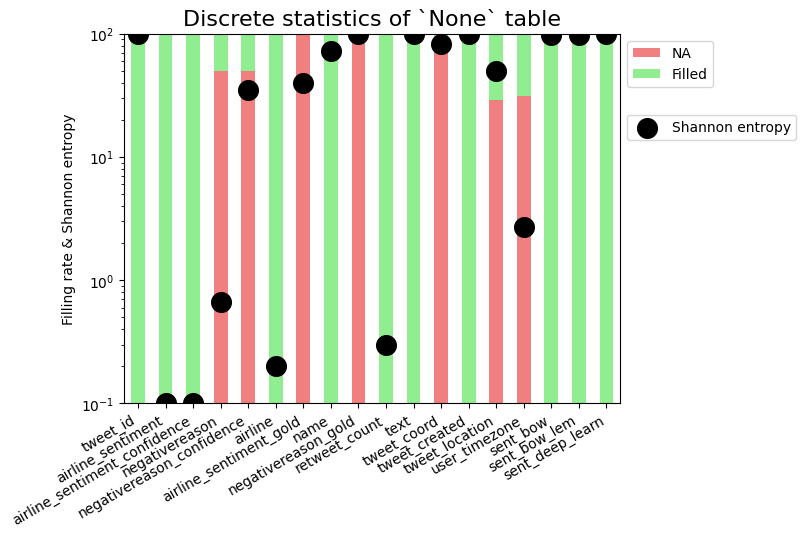

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,sent_bow,sent_bow_lem,sent_deep_learn
tweet_id,,,,,,,,,,,,,,,,,
567861975419457537,positive,1.0,NaN,NaN,United,NaN,JackieFerrari3,NaN,0,@united and they were traveling as guests of a...,NaN,2015-02-17 17:43:39 -0800,Irvine,NaN,united traveling guests mileage plus member us...,united traveling guest mileage plus member usi...,united and they were traveling as guests of a ...
569903840507506688,negative,1.0,Late Flight,0.3456,United,NaN,chefpaulcia,NaN,0,@united sitting in a plane with no pilot. Tha...,NaN,2015-02-23 08:57:18 -0800,NaN,Central Time (US & Canada),united sitting plane pilot thanks waitingonapi...,united sitting plane pilot thanks waitingonapi...,united sitting in a plane with no pilot . than...
569554815539290112,negative,1.0,Late Flight,1.0000,United,NaN,mitchheard,NaN,0,@united this 2 hr delay is a vacation buzzkill,NaN,2015-02-22 09:50:24 -0800,"Austin, TX",Central Time (US & Canada),united delay vacation buzzkill,united delay vacation buzzkill,united this 2 hr delay is a vacation buzzkill
569878117583622145,positive,1.0,NaN,NaN,US Airways,NaN,miscgal,NaN,0,@USAirways Thanks for the information!,NaN,2015-02-23 07:15:05 -0800,NaN,Tehran,usairways thanks information,usairways thanks information,usairways thanks for the information !
569586471570534400,negative,1.0,Late Flight,0.6634,United,NaN,_Charette_,NaN,0,@united unacceptable. 403 was 90 min Late Flig...,NaN,2015-02-22 11:56:11 -0800,SE AZ By Way of HV,Mountain Time (US & Canada),united unacceptable 403 min late flight 'missi...,united unacceptable 403 min late flight 'missi...,united unacceptable . 403 was 90 min late flig...


In [7]:
from example import load
from pepper_commons import show_discrete_stats

old_tweets = load('old_3k_sample_clean.csv')
print(old_tweets.shape)
show_discrete_stats(old_tweets.reset_index())
display(old_tweets.sample(5))

In [8]:
from example import old_encode_cats
import numpy as np
y_cat_num, l_cat = old_encode_cats(old_tweets.airline_sentiment)
print('catégories : ', l_cat)
display(np.unique(y_cat_num, return_counts=True))

catégories :  ['negative', 'positive']


(array([0, 1]), array([1500, 1500], dtype=int64))

In [9]:
from example import encode_cats
cat_codes, cat_labels = encode_cats(tweets.airline_sentiment)
print(cat_labels, len(cat_labels))
display(cat_codes.value_counts())

Index(['negative', 'positive'], dtype='object') 2


0    1500
1    1500
dtype: int64

In [10]:
from example import count_words

old_tweets['bow_len'] = old_tweets.sent_bow.apply(count_words)
print("max sent_bow sentence length : ", old_tweets.bow_len.max())

old_tweets['deep_learn_len'] = old_tweets.sent_deep_learn.apply(count_words)
print("max sent_deep_learn length : ", old_tweets.deep_learn_len.max())

max sent_bow sentence length :  22
max sent_deep_learn length :  42


In [11]:
from example import count_words

tweets['bow_len'] = tweets.sent_bow.apply(count_words)
print("max sent_bow sentence length : ", tweets.bow_len.max())

tweets['deep_learn_len'] = tweets.sent_deep_learn.apply(count_words)
print("max sent_deep_learn length : ", tweets.deep_learn_len.max())

max sent_bow sentence length :  22
max sent_deep_learn length :  41


# Bag of word - Tf-idf

## Préparation des phrases

In [12]:
# création du bag of words (CountVectorizer et Tf-idf)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

old_count_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
old_tf_idf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

old_sent_bow_lem = old_tweets.sent_bow_lem
old_c_sent_bow_lem = old_count_vectorizer.fit_transform(old_sent_bow_lem)
old_f_sent_bow_lem = old_tf_idf_vectorizer.fit_transform(old_sent_bow_lem)

In [13]:
# création du bag of words (CountVectorizer et Tf-idf)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
tf_idf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

sent_bow_lem = tweets.sent_bow_lem
c_sent_bow_lem = count_vectorizer.fit_transform(sent_bow_lem)
f_sent_bow_lem = tf_idf_vectorizer.fit_transform(sent_bow_lem)

Sparsity index: 0.17


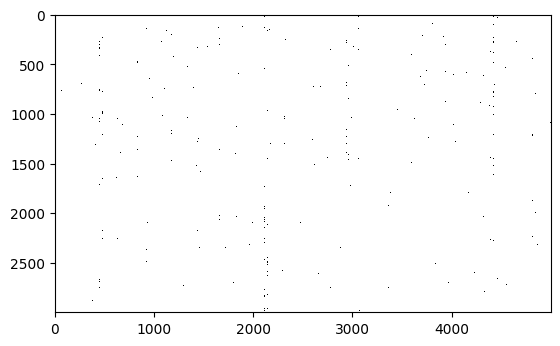

Sparsity index: 0.17


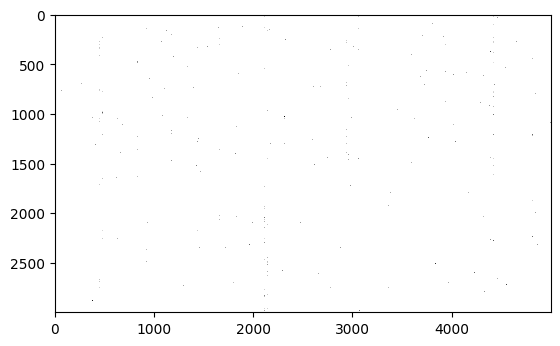

In [14]:
from example import show_sparsity

show_sparsity(old_c_sent_bow_lem)
show_sparsity(old_f_sent_bow_lem)

Sparsity index: 0.17


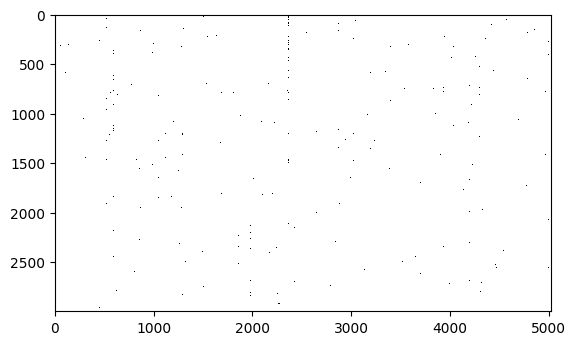

Sparsity index: 0.17


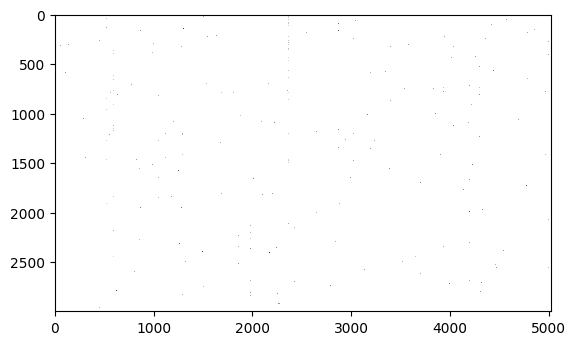

In [15]:
from example import show_sparsity

show_sparsity(c_sent_bow_lem)
show_sparsity(f_sent_bow_lem)

## Exécution des modèles

In [16]:
from example import tsne_kmeans_ari
print("CountVectorizer : ")
print("-----------------")
old_c_X_tsne, old_c_clu_labels, old_c_ari = tsne_kmeans_ari(old_c_sent_bow_lem, y_cat_num, l_cat)
print()
print("Tf-idf : ")
print("--------")
old_f_X_tsne, old_f_clu_labels, old_f_ari = tsne_kmeans_ari(old_f_sent_bow_lem, y_cat_num, l_cat)

CountVectorizer : 
-----------------
T-SNE time: 38.48s
KMeans time: 0.48s
ARI time: 0.00s
Total time : 38.96s

ARI : 0.5163

Tf-idf : 
--------
T-SNE time: 34.43s
KMeans time: 0.39s
ARI time: 0.00s
Total time : 34.82s

ARI : 0.464


In [18]:
from example import tsne_kmeans_ari
print("CountVectorizer : ")
print("-----------------")
c_X_tsne, c_clu_labels, c_ari = tsne_kmeans_ari(c_sent_bow_lem, cat_codes, cat_labels)
print()
print("Tf-idf : ")
print("--------")
f_X_tsne, f_clu_labels, f_ari = tsne_kmeans_ari(f_sent_bow_lem, cat_codes, cat_labels)


CountVectorizer : 
-----------------
T-SNE time: 37.52s
KMeans time: 0.29s
ARI time: 0.00s
Total time : 37.82s

ARI : 0.1004

Tf-idf : 
--------
T-SNE time: 33.36s
KMeans time: 0.32s
ARI time: 0.00s
Total time : 33.67s

ARI : 0.3686


## Graphiques

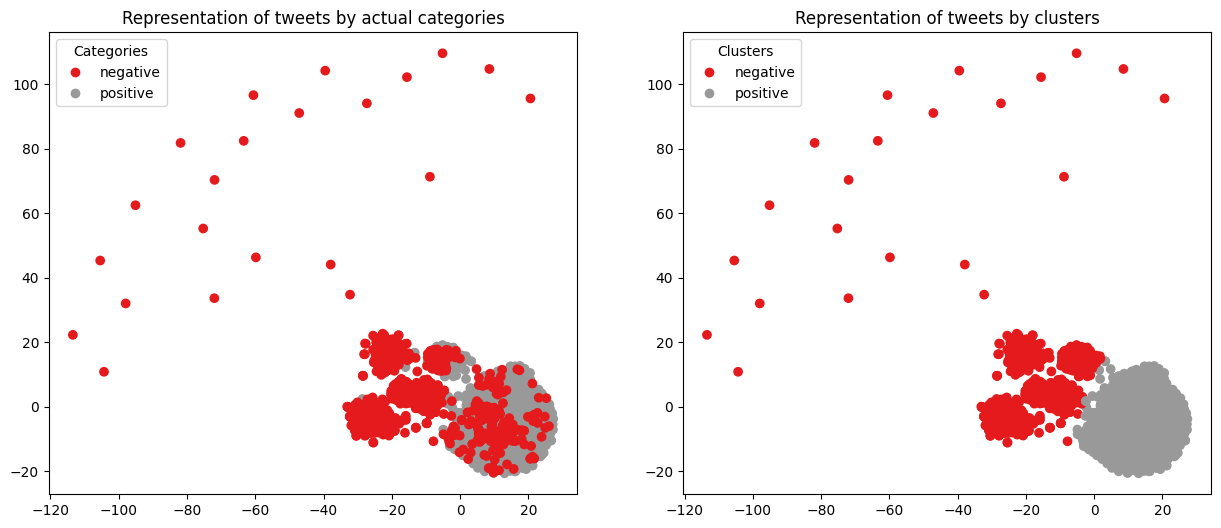

ARI :  0.5163225697543153


In [19]:
from example import show_tsne
show_tsne(y_cat_num, l_cat, old_c_X_tsne, old_c_clu_labels, old_c_ari)

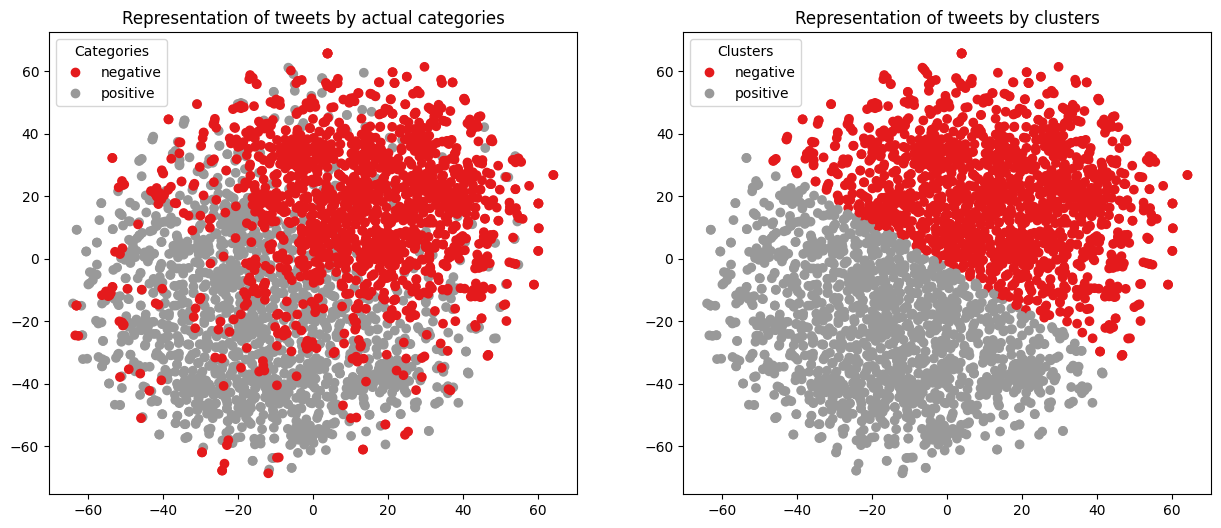

ARI :  0.4640363982766908


In [20]:
from example import show_tsne
show_tsne(y_cat_num, l_cat, old_f_X_tsne, old_f_clu_labels, old_f_ari)

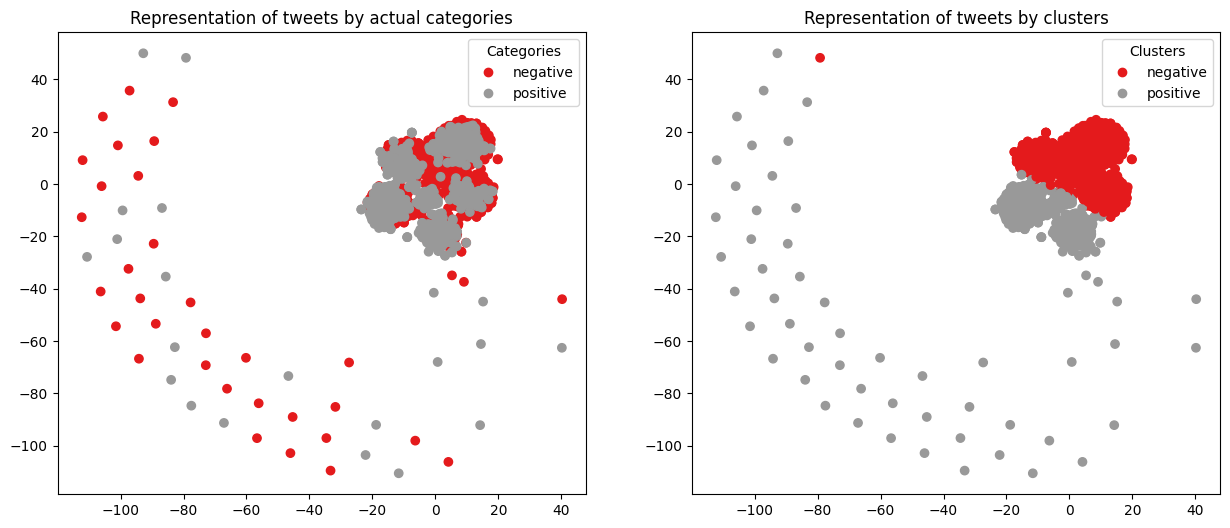

ARI :  0.10041681460828857


In [21]:
from example import show_tsne
show_tsne(cat_codes, cat_labels, c_X_tsne, c_clu_labels, c_ari)

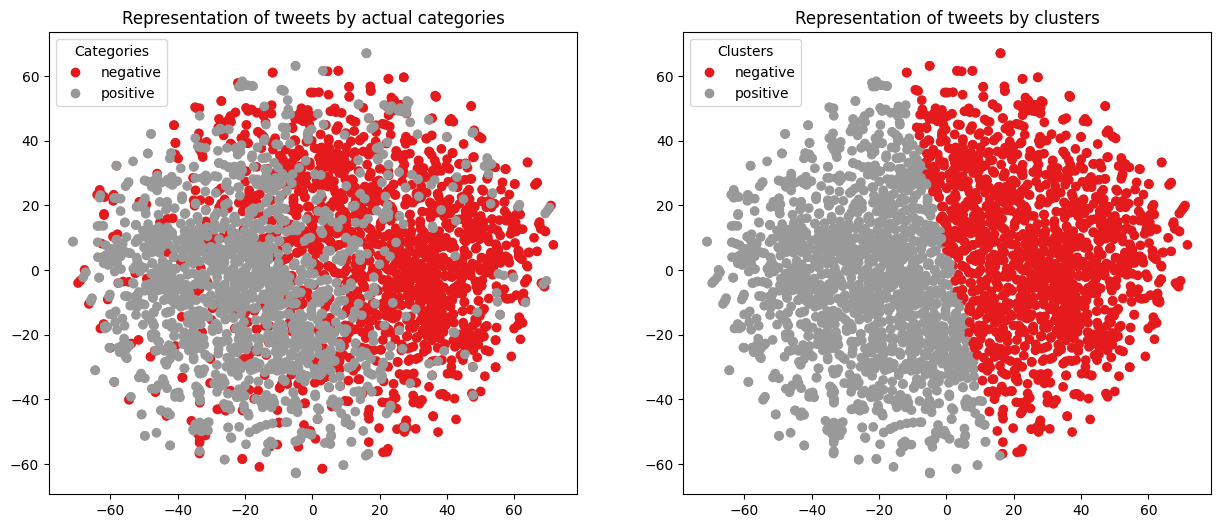

ARI :  0.3686438694429727


In [22]:
from example import show_tsne
show_tsne(cat_codes, cat_labels, f_X_tsne, f_clu_labels, f_ari)

# Word2Vec

ARI : 0.3

Les deux fonctions suivantes concernent la construction d'un modèle d'embedding en utilisant le modèle Word2Vec et le tokenizer Keras. La première fonction `get_embedding_matrix` sert à créer la matrice d'embedding en utilisant le modèle Word2Vec et le tokenizer Keras. Le but est de convertir chaque mot en vecteur à partir du modèle Word2Vec, et de stocker ces vecteurs dans une matrice. La matrice aura la forme `(vocab_size, w2v_size)`, où `vocab_size` est la taille du vocabulaire du tokenizer Keras et `w2v_size` est la dimension du modèle Word2Vec.

La seconde fonction `get_embeddeding_model` sert à construire un modèle Keras qui prend en entrée des phrases tokenizées et renvoie les vecteurs d'embedding associés. Elle crée un modèle Keras avec une entrée de forme `(nombre de phrases, longueur maximale de la phrase)` et renvoie un vecteur d'embedding de longueur `w2v_size` pour chaque phrase. Les poids pré-entraînés de la matrice d'embedding sont attachés à la couche d'embedding du modèle.

## Création du modèle Word2Vec

In [23]:
from example import load
tweets = load('3k_sample_clean.csv')
sent_bow_lem = tweets.sent_bow_lem
display(sent_bow_lem)

tweet_id
569372595067490304    usairways but every time call hold min get dis...
569618884577218560    americanair two delayed flight today n't weath...
568059376474439680    jetblue son left ipad flight 1401 jfk fll mond...
568769216662282240    usairways got drink sat jump seat crossword gl...
570151703410053120    usairways flexibility part would nice this lov...
                                            ...                        
568146157534367744                     virginamerica got all set thanks
568954934084788224    southwestair guy held flight 330 thank about t...
568270768989081600    know lot baggage ... but want know really enjo...
570279118438182913                             americanair great thanks
569670402223562752    southwestair yes please .... how get companion...
Name: sent_bow_lem, Length: 3000, dtype: object

Globals

In [ ]:
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = 24 # adapt to length of sentences

List of lists of Gesim preprocessed words

In [24]:
from example import gesim_simple_preprocess
sents = gesim_simple_preprocess(sent_bow_lem)
print(sents[:5])

[['usairways', 'but', 'every', 'time', 'call', 'hold', 'min', 'get', 'disconnected', 'any', 'way', 'someone', 'help'], ['americanair', 'two', 'delayed', 'flight', 'today', 'weather', 'relate', 'flightd', 'keep', 'good', 'work'], ['jetblue', 'son', 'left', 'ipad', 'flight', 'jfk', 'fll', 'monday', 'called', 'left', 'message', 'heard', 'back', 'seat'], ['usairways', 'got', 'drink', 'sat', 'jump', 'seat', 'crossword', 'glass', 'picked', 'landing', 'just', 'lazy', 'service', 'first', 'class'], ['usairways', 'flexibility', 'part', 'would', 'nice', 'this', 'love', 'southwestair', 'they', 're', 'flexible', 'amp', 'trying', 'take']]


In [25]:
from example import fit_word2vec
w2v_model = fit_word2vec(sents)

Build & train Word2Vec model ...
Vocabulary size: 4807
Word2Vec trained


In [26]:
model_vectors = w2v_model.wv
print(f"model_vectors ({len(model_vectors)}", model_vectors)
w2v_words = model_vectors.index_to_key
print(f"w2v_words ({len(w2v_words)})", w2v_words[:10])
print("flight vector", model_vectors['flight'][:50])

model_vectors (4807 KeyedVectors<vector_size=300, 4807 keys>
w2v_words (4807) ['flight', 'united', 'usairways', 'southwestair', 'americanair', 'jetblue', 'thanks', 'thank', 'service', 'customer']
flight vector [ 0.12280643 -0.32128644  0.18458262 -0.663384   -0.46323898  1.2039722
 -1.2852671  -0.17272186  0.7328015  -0.24370356 -0.16845283  0.29018846
  0.2725152   0.17334802  0.7608986   0.8714662  -0.14006418 -0.8320404
  0.41705796 -0.02216883  0.66423804 -1.1324916  -0.3862315   0.89565206
 -0.01840384 -0.3070044  -0.19247745  0.3689111  -0.15015496 -0.31837457
 -0.4302268  -0.28448793  0.03386861  0.03039574  0.11314146 -0.16320981
 -0.0869737   0.7792061  -0.39196604  0.26629743  0.3743249   0.893198
 -0.4490984  -0.7051848  -0.40599704  1.116065    0.14131601  0.65122145
  0.54219735  0.6337496 ]


In [27]:
from example import fit_keras_tokenizer
keras_tokenizer, x_sents = fit_keras_tokenizer(sents)
display(keras_tokenizer)
print(x_sents.shape)
display(x_sents)

Fit Tokenizer ...
Number of unique words: 4808


(3000, 24)


array([[  3, 204, 221, ...,   0,   0,   0],
       [  5, 103,  30, ...,   0,   0,   0],
       [  6, 623, 168, ...,   0,   0,   0],
       ...,
       [ 68, 247, 130, ...,   0,   0,   0],
       [  5,  14,   7, ...,   0,   0,   0],
       [  4,  99,  48, ...,   0,   0,   0]])

## Création de la matrice d'embedding

In [28]:
from example import get_embedding_matrix
embedding_matrix = get_embedding_matrix(w2v_model, keras_tokenizer)

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix:  (4808, 300)


## Création du modèle d'embedding

In [29]:
from example import get_embedding_model
keras_model = get_embedding_model(x_sents, w2v_model, keras_tokenizer, embedding_matrix)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1442400   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,442,400
Trainable params: 1,442,400
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [30]:
embeddings = keras_model.predict(x_sents)
embeddings.shape

94/94 [==============================] - 0s 2ms/step


(3000, 300)

In [31]:
from example import tsne_kmeans_ari
wve_X_tsne, wve_clu_labels, wve_ari = tsne_kmeans_ari(embeddings, cat_codes, cat_labels)

T-SNE time: 34.45s
KMeans time: 0.36s
ARI time: 0.00s
Total time : 34.81s

ARI : 0.3654


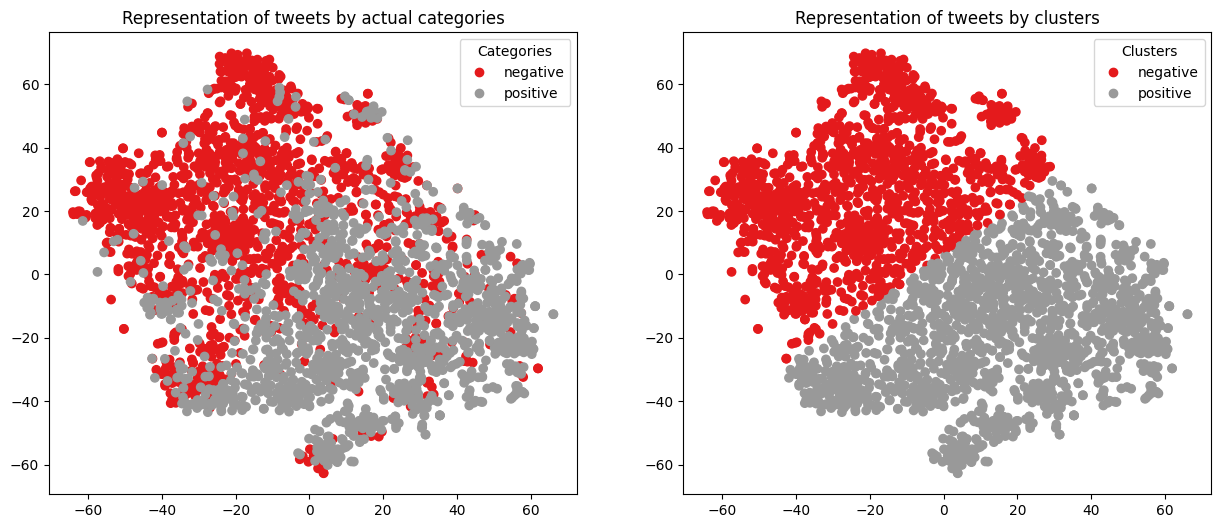

ARI :  0.365413191578968


In [32]:
from example import show_tsne
show_tsne(cat_codes, cat_labels, wve_X_tsne, wve_clu_labels, wve_ari)

# BERT

ARI : 0.5

In [33]:
from example import load, encode_cats
from pepper_commons import show_discrete_stats

tweets = load('3k_sample_clean.csv')
cat_codes, cat_labels = encode_cats(tweets.airline_sentiment)
sents = tweets.sent_deep_learn

In [34]:
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available:", n_gpu)
print("Built with cuda:", tf.test.is_built_with_cuda())

Tensorflow version: 2.11.0
Num GPUs Available: 0
Built with cuda: False


## BERT HuggingFace

### 'bert-base-uncased'

In [35]:
from transformers import TFAutoModel
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [37]:
# Création des features
from example import extract_bert_sentence_embeddings
bert_features, _ = extract_bert_sentence_embeddings(
    model,
    model_type,
    sents, 
    max_length,
    batch_size,
    mode='HF'
)

300/300 [==============================] - 269s 876ms/step


In [38]:
from example import tsne_kmeans_ari
bert_X_tsne, bert_clu_labels, bert_ari = tsne_kmeans_ari(bert_features, cat_codes, cat_labels)

T-SNE time: 29.25s
KMeans time: 0.23s
ARI time: 0.00s
Total time : 29.48s

ARI : 0.4833


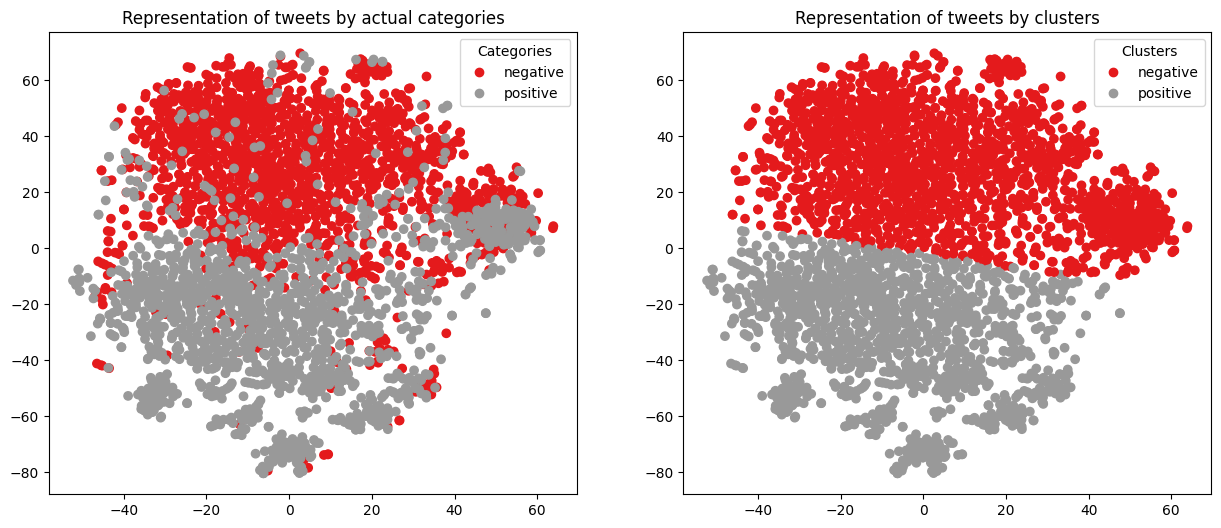

ARI :  0.4833182444089832


In [39]:
from example import show_tsne
show_tsne(cat_codes, cat_labels, bert_X_tsne, bert_clu_labels, bert_ari)

# USE - Universal Sentence Encoder

ARI : 0.6

In [40]:
from example import load, encode_cats
from pepper_commons import show_discrete_stats

tweets = load('3k_sample_clean.csv')
cat_codes, cat_labels = encode_cats(tweets.airline_sentiment)
sents = tweets.sent_deep_learn

In [41]:
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available:", n_gpu)
print("Built with cuda:", tf.test.is_built_with_cuda())

Tensorflow version: 2.11.0
Num GPUs Available: 0
Built with cuda: False


In [43]:
# Création des features
from example import extract_use_sentence_embeddings
use_features = extract_use_sentence_embeddings(sents)

USE time: 2.12s


In [47]:
from example import tsne_kmeans_ari
use_X_tsne, use_clu_labels, use_ari = tsne_kmeans_ari(use_features, cat_codes, cat_labels)

T-SNE time: 29.19s
KMeans time: 0.26s
ARI time: 0.00s
Total time : 29.45s

ARI : 0.5958


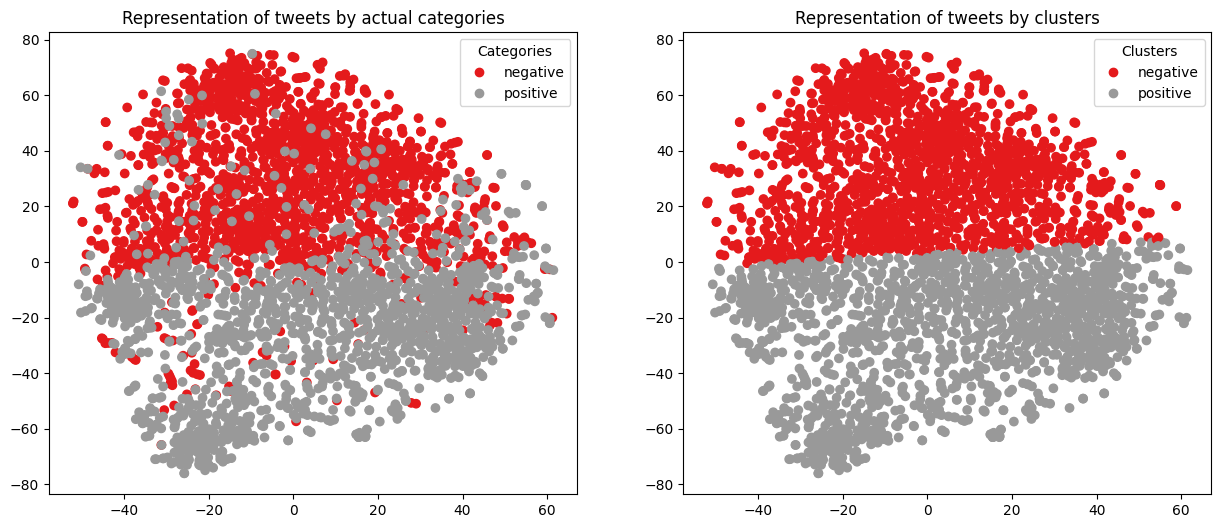

ARI :  0.5958495842224893


In [48]:
from example import show_tsne
show_tsne(cat_codes, cat_labels, use_X_tsne, use_clu_labels, use_ari)